# Goals
The primary goal of this notebook is to revisit the Dengue fever epidemic study and try more techniques. These include:
* Using PyTorch instead of TensorFlow
* Trying RNNs (GRU and LSTM) and/or CNN
    * This will likely require reworking how the input data is formatted
    

For reference: the previous versions:
https://www.kaggle.com/code/michaeloliver137/dengue-study-v3
https://www.kaggle.com/code/michaeloliver137/dengue-study-v2
https://www.kaggle.com/code/michaeloliver137/dengue-study

# Notes on the Data Source

The dataset on Kaggle has defined training and testing datasets, with labels (the total weekly cases of Dengue) only for the training set. Thus, the test set can't be used locally, especially if we are using the time series of cases as a feature.

In [1]:
!pip install einops

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.2 MB/s eta 0:00:00


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

# New Tools
from einops import rearrange, reduce, repeat


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


/kaggle/input/epidemy/dengue_labels_train.csv
/kaggle/input/epidemy/dengue_features_train.csv
/kaggle/input/epidemy/dengue_features_test.csv
/kaggle/input/epidemy/submission_format.csv


In [3]:
# Check the device information
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
dengue_features_train = pd.read_csv('../input/epidemy/dengue_features_train.csv',parse_dates=True)
#dengue_features_test = pd.read_csv('../input/epidemy/dengue_features_test.csv',parse_dates=True)
dengue_labels_train   = pd.read_csv('../input/epidemy/dengue_labels_train.csv',parse_dates=True)


In [5]:
for col in dengue_features_train.columns:
    print(col)

city
year
weekofyear
week_start_date
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm


# Cleaning the data
* This dataset has an issue with an inconsistency in how the dates and week number are encoded, which need to be corrected.
* For simplicity, the data will be converted to an index of the number of weeks since a given starting point

In [6]:
from datetime import date, timedelta
import datetime
import math

debug_date_map=True

# store information on 
date_map_debug_logs=[]

set_of_bad_years=set()

# map from dataframe with year, weekofyear features
# to a time index
# lets go with weeks since day 1 of week 1 of 1990
def date_start_map(x):
    year_one=1990
    week_one=1
    day_of_week=1
    # Trying thursday
    date_one = datetime.datetime.strptime(f"{year_one}-U{week_one}-{day_of_week}","%Y-U%U-%w").date()

    year_current = x['year']
    week_current = x['weekofyear']


    # trouble years are those where this data set incorrectly assigns a week at the 
    # beginning to the end. I've identified these as those starting with Friday, Saturday,
    # or Sunday
    raw_year_current = year_current
    raw_week_current = week_current
    trouble_year=False
    shift = 0
    year_start_date = datetime.datetime.strptime(f"{year_current}-M{1}-{1}","%Y-M%m-%d").date()

    date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()
    if (year_start_date.weekday() >= 4):
        trouble_year=True
        set_of_bad_years.add(year_current)
        # need better check
        if (week_current >= 52):
            year_current-=1
            # trying to assign to Dec 31
            date_two = datetime.datetime.strptime(f"{year_current}-M{12}-{31}","%Y-M%m-%d").date()
        else:
            shift = 1
            date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()    
    time_d = date_two - date_one
    weeks = math.ceil(time_d.days / 7.0)
    weeks += shift
    if debug_date_map:
        debug_log=f"{raw_year_current}-{raw_week_current} mapped to week {weeks} using days {time_d.days}"
        date_map_debug_logs.append(debug_log)
    
    return weeks
startmap=date_start_map

dengue_features_train['weeks_since_start']=dengue_features_train.apply(startmap,axis=1)
#dengue_features_test['weeks_since_start']=dengue_features_test.apply(startmap,axis=1)
dengue_labels_train['weeks_since_start']=dengue_labels_train.apply(startmap,axis=1)

dengue_features_sj_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='sj'])
#dengue_features_sj_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='sj'])
dengue_labels_sj_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='sj'])

dengue_features_iq_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='iq'])
#dengue_features_iq_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='iq'])
dengue_labels_iq_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='iq'])

list_of_frames=[
    dengue_features_sj_train,
#    dengue_features_sj_test,
    dengue_labels_sj_train,
    dengue_features_iq_train,
 #   dengue_features_iq_test,
    dengue_labels_iq_train
]
for frame in list_of_frames:
    frame.sort_values('weeks_since_start',inplace=True)
    frame.set_index('weeks_since_start',inplace=True)


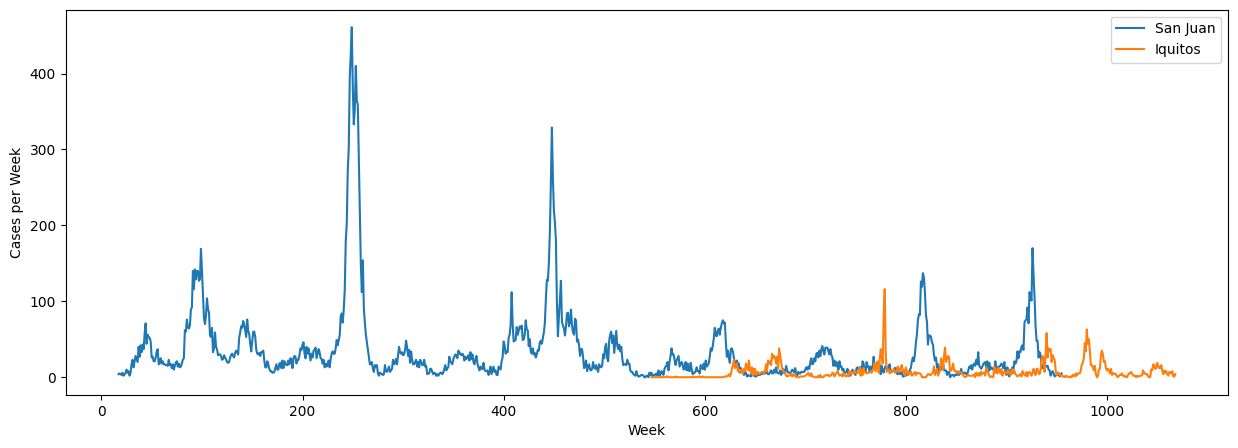

In [7]:
ax=dengue_labels_sj_train.loc[:,['total_cases']].plot(figsize=(15,5))
dengue_labels_iq_train.loc[:,['total_cases']].plot(ax=ax)
ax.legend(['San Juan','Iquitos'])
ax.set(xlabel="Week",ylabel="Cases per Week")
plt.savefig('cases_data.png')

/tmp/ipykernel_19/3165129045.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((len(features_to_plot), 1), (0, 0), colspan=1)
/tmp/ipykernel_19/3165129045.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((len(features_to_plot), 1), (i, 0), colspan=1)
/tmp/ipykernel_19/3165129045.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((len(features_to_plot), 1), (i, 0), colspan=1)
/tmp/ipykernel_19/3165129045.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor release

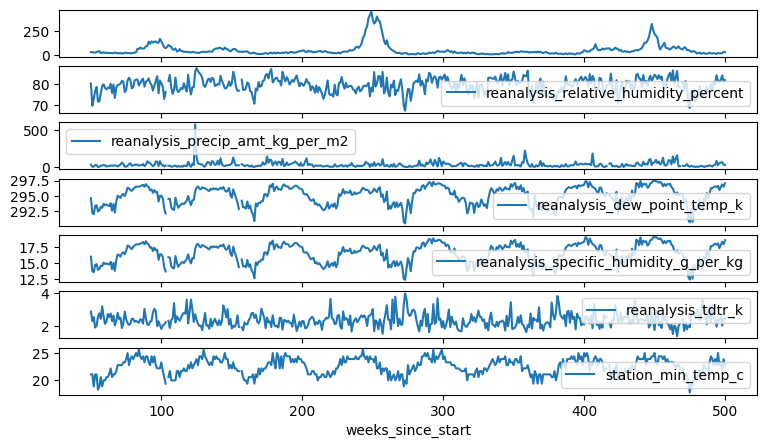

In [8]:
start_week=50
end_week=500

features_to_plot=['total_cases',
                  'reanalysis_relative_humidity_percent',
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_tdtr_k',
                 'station_min_temp_c']
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, sharex=True, sharey=False)
for i in range(len(features_to_plot)):
    feat_to_plot = features_to_plot[i]
    if feat_to_plot == 'total_cases':
        figsize=(9,5)
        ax1 = plt.subplot2grid((len(features_to_plot), 1), (0, 0), colspan=1)
        dengue_labels_sj_train.loc[start_week:end_week,feat_to_plot].plot(ax=ax1,figsize=figsize)
    else:
        ax2 = plt.subplot2grid((len(features_to_plot), 1), (i, 0), colspan=1)
        dengue_features_sj_train.loc[start_week:end_week,feat_to_plot].plot(ax=ax2,label=feat_to_plot)
        ax2.legend()

In [9]:
dengue_features_sj_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

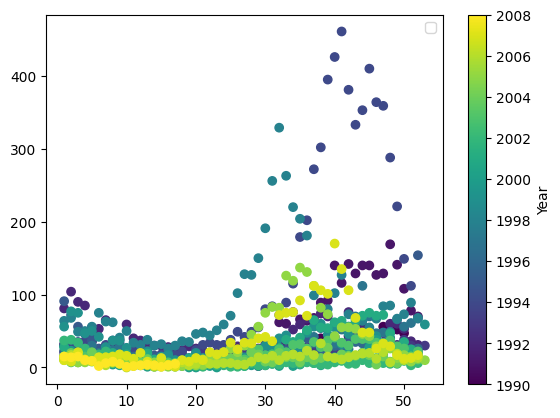

In [10]:
figs, ax = plt.subplots()
scatter_plot = ax.scatter(dengue_features_sj_train['weekofyear'],dengue_labels_sj_train['total_cases'],
                          c=dengue_features_sj_train['year'],cmap='viridis',marker='o')
plt.colorbar(scatter_plot, label='Year')
ax.legend()

# Partial Auto Correlation 
Using the Partial Auto-Correlation computation to show the strong auto-correlation and give an estimate of how long the time-dependence is.

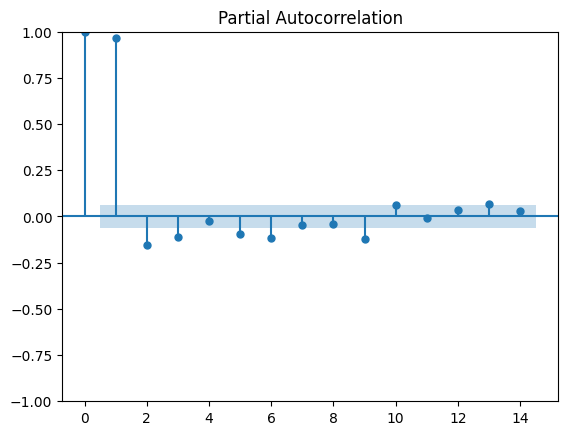

In [11]:
#from learntools.time_series.utils import plot_lags, make_lags, make_leads
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dengue_labels_sj_train['total_cases'], lags=14);
plt.savefig('cases_sj_pacf.png')

In [12]:
dengue_features_sj_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
18,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
19,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
20,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
21,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


# Target
The goal is to predict future rates of Dengue. We can start by making predictions for a specific number of weeks in the future, and maybe expand that to multi-week targets, like done in previous versions of this study.

In [13]:
num_target_lags = 3

#y_sj = dengue_features_sj_train[]
#y_sj_lags=make_lags(dengue_labels_sj_train['total_cases'],lags=target_lag_number)
y_sj = pd.concat({ f"y_step_{i}":dengue_labels_sj_train['total_cases'].shift(-i) for i in range(1,num_target_lags+1)},axis=1)
#.DataFrame({f"target_lead})
y_sj

,y_step_1,y_step_2,y_step_3
weeks_since_start,,,
17,5.0,4.0,3.0
18,4.0,3.0,6.0
19,3.0,6.0,2.0
20,6.0,2.0,4.0
21,2.0,4.0,5.0
...,...,...,...
951,3.0,1.0,3.0
952,1.0,3.0,5.0
953,3.0,5.0,NaN


We should remember to remove rows with NaN later.

In [14]:
#Not_NaN_rows = y_sj.hasnans()
Not_NaN_rows  = y_sj.dropna().index
print(Not_NaN_rows)
#print(y_sj.iloc[Not_NaN_rows])

Index([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
       ...
       943, 944, 945, 946, 947, 948, 949, 950, 951, 952],
      dtype='int64', name='weeks_since_start', length=933)


# Features to Train on

The variables of interest, except perhaps the dates, are all floating point variables. For the dates, it might be of interest to add fourier features to directly include seasonality. The relative utility of this might be limited by the fact that many of of the physical variables are essentially already fourier features, and may be more directly connected to the physical causes of seasonality.

We will also include the Dengue fever rates for each time, from the labels. 

In [15]:
#dengue_features_sj_train.columns[dengue_features_sj_train.dtypes.str.contains('float')]

features_to_train = dengue_features_sj_train.select_dtypes(include="float").columns.tolist()
print(features_to_train)

['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']


In [16]:
#features_to_train = []
primary_data_sj = dengue_features_sj_train[features_to_train]
primary_data_sj = pd.concat([dengue_labels_sj_train['total_cases'],primary_data_sj],axis=1)
primary_data_sj

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,4,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
18,5,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
19,4,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
20,3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
21,6,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,4,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
952,3,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
953,1,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7


In [17]:
y_sj

,y_step_1,y_step_2,y_step_3
weeks_since_start,,,
17,5.0,4.0,3.0
18,4.0,3.0,6.0
19,3.0,6.0,2.0
20,6.0,2.0,4.0
21,2.0,4.0,5.0
...,...,...,...
951,3.0,1.0,3.0
952,1.0,3.0,5.0
953,3.0,5.0,NaN


In [18]:
primary_data_sj = primary_data_sj.loc[Not_NaN_rows]
y_sj = y_sj.loc[Not_NaN_rows]

# Train-Test Split

In [19]:
test_size = 400

X_train, X_valid, y_train, y_valid = train_test_split(primary_data_sj,y_sj,test_size=test_size,shuffle=False)



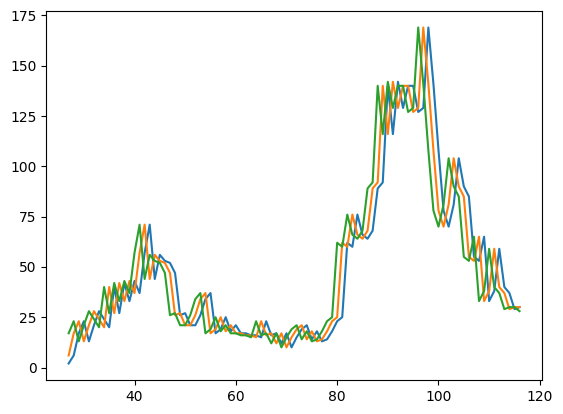

In [20]:
plt.plot(y_train.iloc[10:100])

# Feature Engineering

Normalize the data using the training set

In [21]:
X_train_mean = X_train.mean()
X_train_std  = X_train.std()

X_train = (X_train - X_train_mean) / X_train_std
X_valid = (X_valid - X_train_mean) / X_train_std

X_train.fillna(0,inplace=True)
X_valid.fillna(0,inplace=True)

X_train.head(16)

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,-0.647038,0.372245,0.064464,0.422792,0.205884,-0.533663,-1.154417,-1.125519,-1.625845,-1.142170,...,-0.061024,-1.692574,-0.533663,-1.552617,0.617755,-1.145274,-0.001303,-1.403901,-1.671480,-0.322811
18,-0.631100,0.884549,0.564553,-0.262292,-0.206693,-0.276899,-0.602478,-0.510028,-0.663654,-0.211317,...,-0.414268,-0.551473,-0.276899,-0.688645,0.031814,-0.232926,-0.623281,-0.028709,-0.228617,-0.588468
19,-0.647038,-0.606331,0.965036,-0.360089,0.079603,0.012455,-0.109808,-0.126916,0.264557,-0.549809,...,-0.209256,0.783884,0.012455,0.248838,-0.130947,-0.232926,-0.488799,0.270246,0.164892,0.589038
20,-0.662977,0.437592,1.902783,0.974136,1.292163,-0.461078,0.067998,0.180829,0.186759,0.211797,...,-0.515770,0.294782,-0.461078,0.137211,0.162023,0.310381,-0.152595,0.927947,0.492815,-0.753607
21,-0.615162,1.169403,2.125622,1.422491,1.505700,-0.654638,0.527330,0.563941,0.506893,0.634912,...,-0.558481,0.329805,-0.654638,0.478444,1.496666,1.366244,2.906864,1.944393,0.886323,-0.688987
22,-0.678915,0.000000,0.989531,1.481550,0.282806,-0.603779,0.623642,0.651868,0.525672,1.058027,...,-0.199457,0.167722,-0.603779,0.480259,-0.586679,0.771680,0.049128,1.585647,0.886323,0.506469
23,-0.647038,0.267185,-0.077628,0.547726,0.814649,-0.754381,0.258152,0.174549,0.534614,0.127174,...,0.104796,0.768816,-0.754381,0.493872,-0.716888,0.269377,-0.152595,0.270246,0.492815,0.169013
24,-0.631100,-0.170385,-0.341654,-0.468724,-0.625350,2.890683,0.590303,0.444611,0.951325,-0.465186,...,-0.111272,1.160992,2.890683,0.965789,-1.791113,0.956200,0.923259,1.286692,0.164892,-0.139723
25,-0.551409,0.154002,0.616578,-0.959882,-0.801122,-0.363310,0.579190,0.469733,0.855643,0.804158,...,0.077410,0.987913,-0.363310,0.846902,-1.074963,0.925447,0.570244,1.286692,0.164892,-0.139723


# Build Batches for model

In [22]:
X_train.head(1)

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
17,-0.647038,0.372245,0.064464,0.422792,0.205884,-0.533663,-1.154417,-1.125519,-1.625845,-1.14217,...,-0.061024,-1.692574,-0.533663,-1.552617,0.617755,-1.145274,-0.001303,-1.403901,-1.67148,-0.322811


In [23]:
X_train.iloc[2:3,:]

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
weeks_since_start,,,,,,,,,,,,,,,,,,,,,
19,-0.647038,-0.606331,0.965036,-0.360089,0.079603,0.012455,-0.109808,-0.126916,0.264557,-0.549809,...,-0.209256,0.783884,0.012455,0.248838,-0.130947,-0.232926,-0.488799,0.270246,0.164892,0.589038


In [24]:
input_size = X_train.shape[1]
X_train.shape

(533, 21)

In [25]:
class MyDataLoader:
    def __init__(self,data_source,label_source,batch_size=16,randomize_start=False):
        # data_source should be a data-frame
        self.data = data_source
        self.labels = label_source
        self.batch_size = batch_size
        self.randomize_start = randomize_start
        
    def __iter__(self):
        if self.randomize_start:
            self.current_index = torch.randint(low=0, high=self.batch_size, size=(1,)).item()
        else:
            self.current_index = 0
        return self
        
    def __len__(self):
        return int(self.data.shape[0] / self.batch_size)
        
    def __next__(self):        
        local_index = self.current_index

        if local_index + self.batch_size > self.data.shape[0]:
            # reset
            self.current_index = 0
            raise StopIteration
        
        self.current_index += self.batch_size
        result_data = self.data.iloc[local_index:local_index + self.batch_size]
        tensor_data = torch.tensor(result_data.values, dtype=torch.float32)
        
        result_label = self.labels.iloc[local_index:local_index + self.batch_size]
        tensor_label = torch.tensor(result_label.values, dtype=torch.float32)
        
        # does this need to be grad enabled?
        return tensor_data,tensor_label
        

In [26]:
# testing data loader
data_loader = MyDataLoader(X_train,y_train,batch_size=16,randomize_start=False)
count = 0
num_batches = 0

for batch in data_loader:
    data,label = batch
    print(data.shape,label.shape)
    num_batches += 1

next_batch = next(data_loader)
data,label = next_batch
print(data)
print(label)

torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 21]) torch.Size([16, 3])
torch.Size([16, 

# Building Models

In [27]:
debug_nn = False


class MyNetwork_Basic(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
                
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,output_size),
        )
    def forward(self,x):
        if (debug_nn):
            print(x.shape)
        x = self.linear_relu_stack(x)
        if (debug_nn):
            print(x.shape)
        #x = F.relu(x) # because the output is non-negative
        return x

class MyNetwork(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        
        self.lstm1 = nn.LSTM(input_size,32,num_layers=2)
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,output_size),
        )
    def forward(self,x):
        if (debug_nn):
            print(x.shape)
        x, (h_n, c_n) = self.lstm1(x)
        if (debug_nn):
            print(x.shape)
        x = self.linear_relu_stack(x)
        if (debug_nn):
            print(x.shape)
        return x

In [28]:
torch.manual_seed(0)
print(input_size,num_target_lags)
model = MyNetwork(input_size,num_target_lags).to(device)
#model = MyNetwork_Basic(input_size,num_target_lags).to(device)
print(model)

21 3
MyNetwork(
  (lstm1): LSTM(21, 32, num_layers=2)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


# Train


In [29]:
def LossFunction(result, target):
    return torch.mean((result - target)**2)

In [30]:
#criterion = nn.MSELoss()
criterion = LossFunction
optimizer = optim.SGD(model.parameters(), lr=0.0005)
scheduler = ExponentialLR(optimizer, gamma=0.995)
num_epochs = 10

In [31]:
data_loader = MyDataLoader(X_train,y_train,batch_size=64,randomize_start=True)
num_batches = len(data_loader)
count = 0

debug_train = False

print_steps = 10
print_steps_batch = 1

num_epochs = 300

loss_train_list = []

for epoch in range(num_epochs):
    for batch_id, batch in enumerate(data_loader):
        data, label = batch
        
        data  = data.to(device)
        label = label.to(device)
        
        model.train()
        
        output = model(data)
        
        if (debug_train):
            print(output)
            print(label)
        
        loss = criterion(output,label)
        loss_train_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_id + 1) % (print_steps_batch) == 0:
            progress = 100.0 * batch_id / num_batches
            print(f"\tEpoch {epoch+1}, batch {batch_id + 1}. progress {progress:.2f}%, Loss: {loss.item():.4f}",end='\r')
            
    scheduler.step() # try stepping the schedulear at the epoch level       
    if (epoch + 1) % print_steps == 0:
        print(f"\nEpoch {epoch+1}, Loss: {loss.item():.4f}")

	Epoch 10, batch 7. progress 75.00%, Loss: 4559.3208
Epoch 10, Loss: 4559.3208
	Epoch 20, batch 7. progress 75.00%, Loss: 420.8355
Epoch 20, Loss: 420.8355
	Epoch 30, batch 8. progress 87.50%, Loss: 458.9965
Epoch 30, Loss: 458.9965
	Epoch 40, batch 8. progress 87.50%, Loss: 118.6645
Epoch 40, Loss: 118.6645
	Epoch 50, batch 7. progress 75.00%, Loss: 150.3497
Epoch 50, Loss: 150.3497
	Epoch 60, batch 8. progress 87.50%, Loss: 106.8433
Epoch 60, Loss: 106.8433
	Epoch 70, batch 8. progress 87.50%, Loss: 93.8924
Epoch 70, Loss: 93.8924
	Epoch 80, batch 7. progress 75.00%, Loss: 135.8345
Epoch 80, Loss: 135.8345
	Epoch 90, batch 7. progress 75.00%, Loss: 391.1233
Epoch 90, Loss: 391.1233
	Epoch 100, batch 7. progress 75.00%, Loss: 110.3385
Epoch 100, Loss: 110.3385
	Epoch 110, batch 7. progress 75.00%, Loss: 88.7521
Epoch 110, Loss: 88.7521
	Epoch 120, batch 7. progress 75.00%, Loss: 99.9942
Epoch 120, Loss: 99.9942
	Epoch 130, batch 7. progress 75.00%, Loss: 350.7881
Epoch 130, Loss: 350.

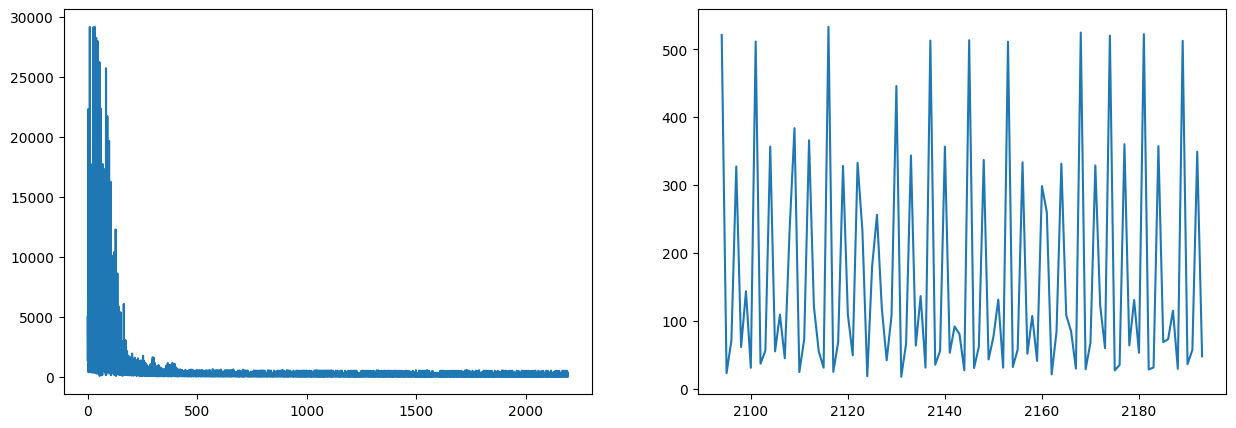

In [32]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(loss_train_list)
ax[1].plot(range(len(loss_train_list)-100,len(loss_train_list)),loss_train_list[-100:])

# Evaluating Results

In [33]:
tensor_X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
tensor_y_valid = torch.tensor(y_valid.values, dtype=torch.float32)
with torch.no_grad():
    model.eval()
    output = model(tensor_X_valid)

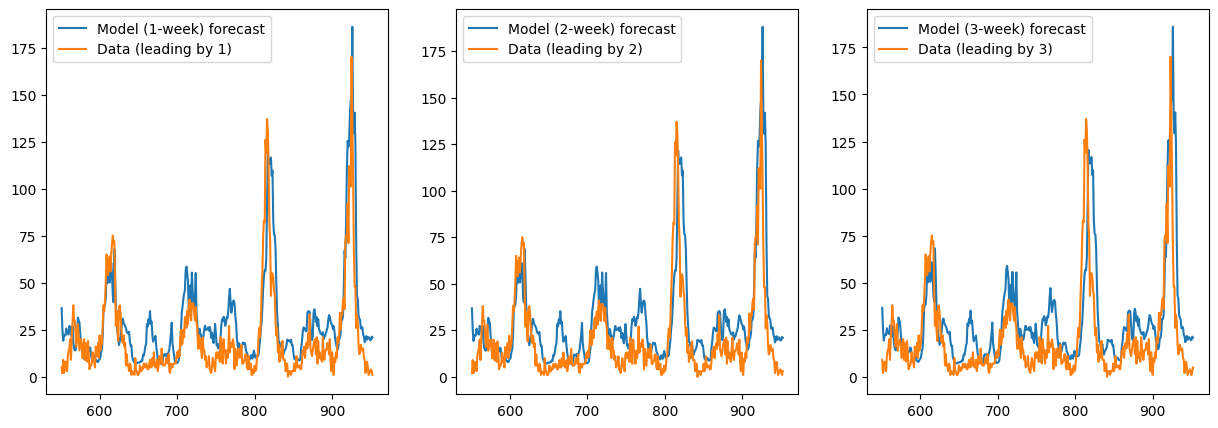

In [34]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

step_index = 1

for step_index in range(0,3):

    ax[step_index].plot(y_valid.index,output[:,step_index],label=f"Model ({step_index+1}-week) forecast")
    ax[step_index].plot(y_valid[f'y_step_{step_index+1}'],label=f"Data (leading by {step_index+1})")
    ax[step_index].legend()

plt.savefig('Model_Valid_Predictions.png')